In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
def get_holidays(years):
    holidays = list()
    for year in years:
        holidays_wrong = pd.read_json('https://api.calendario.com.br/?json=true&ano=%s&ibge=2304400&token=bWFkc29uZGRpYXNAZ21haWwuY29tJmhhc2g9MTIzNDc0NTU0' % year).date.astype('str').values
        holidays.extend(['%s-%s-%s' % (x.split('-')[0], x.split('-')[2], x.split('-')[1]) for x in holidays_wrong])
    return holidays

In [59]:
path_name = '../data/climate/'
file_names_pr = ['24279', '24319', '24320', '24321']
file_names_t  = ['225', '572']

df_final = pd.DataFrame()

for file_name in file_names_pr:
    df_ = pd.read_csv(path_name+'pr/'+file_name+'.csv')
    df_final[file_name] = df_['pr']

for file_name in file_names_t:
    df_final['avg_tmp_'+file_name] = pd.read_csv(path_name+'t2m/'+file_name+'.csv')['avg_tmp']
    df_final['max_tmp_'+file_name] = pd.read_csv(path_name+'t2mmax/'+file_name+'.csv')['max_tmp']
    df_final['min_tmp_'+file_name] = pd.read_csv(path_name+'t2mmin/'+file_name+'.csv')['min_tmp']
    
df_['year']  = df_['year'].astype('object')
df_['month'] = df_['month'].astype('object')
df_['day']   = df_['day'].astype('object')

df_['dia'] = df_.apply(lambda x: '%s-%s-%s' % (x['year'], str(x['month']).zfill(2), str(x['day']).zfill(2)), axis=1)

df_final = df_final.assign(weekday=df_.apply(lambda x: datetime.strptime('%s-%s-%s' % (x['year'],x['month'],x['day']),'%Y-%m-%d').weekday(), axis=1),
                           dia=df_['dia'])

holidays_list = get_holidays(['2014','2015','2016', '2017'])
df_final = df_final.assign(holiday=df_.apply(lambda x: 1 if '%s-%s-%s' % (str(x['year']), str(x['month']).zfill(2),str(x['day']).zfill(2)) in holidays_list else 0, axis=1))
df_final = df_final.assign(workingday=df_final.apply(lambda x: 1 if x['holiday']==1 or x['weekday'] in [5,6] else 0, axis=1))
df_final = df_final.assign(avg_pr=df_final[file_names_pr].mean(axis=1))
df_final = df_final.assign(max_pr=df_final[file_names_pr].max(axis=1))
df_final = df_final.assign(min_pr=df_final[file_names_pr].min(axis=1))
df_final = df_final.assign(avg_tmp=df_final[['avg_tmp_225','avg_tmp_572']].mean(axis=1))
df_final = df_final.assign(min_tmp=df_final[['min_tmp_225','min_tmp_572']].mean(axis=1))
df_final = df_final.assign(max_tmp=df_final[['max_tmp_225','max_tmp_572']].mean(axis=1))
df_final = df_final.drop(['avg_tmp_225','avg_tmp_572','min_tmp_225','min_tmp_572','max_tmp_225','max_tmp_572'], axis=1)
df_final = df_final.drop(file_names_pr, axis=1)
df_final = df_final.fillna(df_final.mean())

df_final = df_final.set_index('dia')
df_final = df_final.iloc[349:]

df_viagens = pd.read_csv('../data/bicicletar/graph_datasets/rides_per_sex.csv', index_col='dia')

In [60]:
aa = pd.concat([df_final, df_viagens], axis=1)
aa = aa.fillna(0)

/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


/home/omadson/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


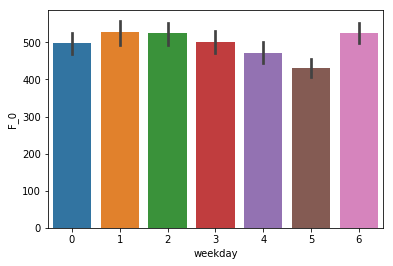

In [96]:
%matplotlib inline
import seaborn as sns

sns.barplot(x='weekday', y='F_0', data=aa)

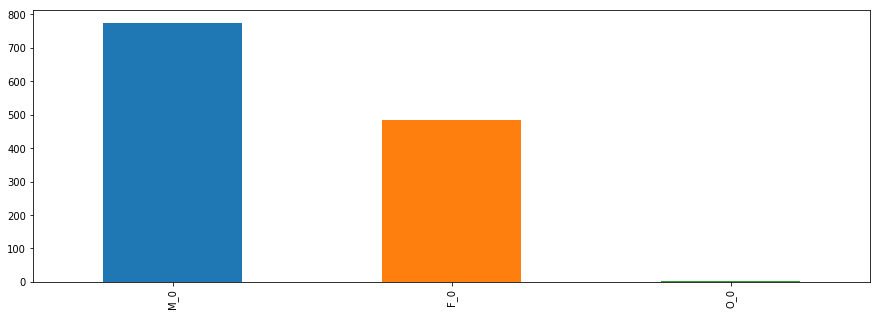

In [114]:
aa[aa['holiday'] == 1][['M_0','F_0','O_0']].mean().plot.bar(figsize=(15,5))

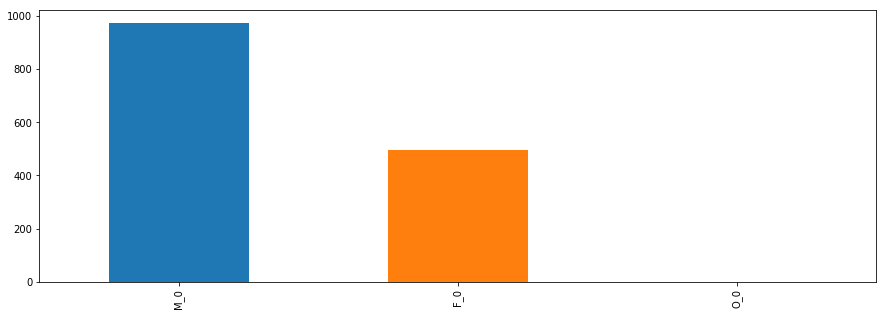

In [115]:
aa[aa['holiday'] == 0][['M_0','F_0','O_0']].mean().plot.bar(figsize=(15,5))